In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import time
import numpy as np
import pandas as pd

# BESOS
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP, EvaluatorGeneric
from besos.parameters import (
    Parameter,
    RangeParameter,
    FieldSelector,
    expand_plist,
    wwr,
    CategoryParameter,
    GenericSelector
)
from besos.problem import EPProblem, Problem
from besos.optimizer import NSGAII

# Visualización
import matplotlib.pyplot as plt
from seaborn import heatmap, pairplot
from plotly import express as px

# Scikit-learn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import warnings

from epw import epw

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
building = ef.get_building("Res-Flat2_IDF.idf")
epw_file='Larnaca_Larnax_Airp_-hour.epw'

In [4]:
meteo = epw()
meteo.read(epw_file)
meteo.dataframe.describe()

,Year,Month,Day,Hour,Minute,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,Extraterrestrial Horizontal Radiation,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
count,8760.0,8760.000000,8760.000000,8760.000000,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.0,8760.0,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.0
mean,2005.0,6.526027,15.720548,12.500000,60.0,13.459167,7.302180,67.973630,100858.916324,289.739269,...,99999.0,9.0,999999999.0,16.600685,0.174258,0.015183,74.213014,0.201285,0.051541,99.0
std,0.0,3.448048,8.796749,6.922582,0.0,6.417562,5.387262,14.378834,272.243386,374.530939,...,0.0,0.0,0.0,6.329907,0.060578,0.184135,26.073199,0.017504,0.314345,0.0
min,2005.0,1.000000,1.000000,1.000000,60.0,-1.900000,-8.800000,27.000000,100069.000000,0.000000,...,99999.0,9.0,999999999.0,5.000000,0.039000,0.000000,0.000000,0.200000,0.000000,99.0
25%,2005.0,4.000000,8.000000,6.750000,60.0,8.700000,3.500000,57.000000,100661.000000,0.000000,...,99999.0,9.0,999999999.0,12.000000,0.126000,0.000000,76.000000,0.200000,0.000000,99.0
50%,2005.0,7.000000,16.000000,12.500000,60.0,13.200000,7.400000,68.000000,100849.000000,16.000000,...,99999.0,9.0,999999999.0,16.000000,0.181000,0.000000,88.000000,0.200000,0.000000,99.0
75%,2005.0,10.000000,23.000000,18.250000,60.0,18.300000,11.200000,79.000000,101066.000000,546.000000,...,99999.0,9.0,999999999.0,20.000000,0.218000,0.000000,88.000000,0.200000,0.000000,99.0
max,2005.0,12.000000,31.000000,24.000000,60.0,33.200000,22.800000,100.000000,101547.000000,1190.000000,...,99999.0,9.0,999999999.0,46.000000,0.338000,3.000000,88.000000,0.607000,7.500000,99.0


In [3]:
roof_ins = FieldSelector(class_name='Material',
                         object_name='MW Glass Wool (rolls)_.0001',
                         field_name='Thickness')
wall_ins = FieldSelector(class_name='Material', 
                         object_name='_Insulation_.0001', 
                         field_name='Thickness')

wall_range = RangeParameter(min_val=0.1,max_val=1.0)
roof_range = RangeParameter(min_val=0.1,max_val=1.0)

insulation_param = [Parameter(selector=wall_ins,
                                 value_descriptor=wall_range ,
                                 name='Wall Insulation'),
                   Parameter(selector=roof_ins,
                                 value_descriptor=roof_range ,
                                 name='Roof Insulation')]

In [7]:
ventAchRange = RangeParameter(min_val = 0.0, max_val=6.0)

ventilationAchParam = []


ventACH_sel = FieldSelector(class_name = 'ZoneVentilation:DesignFlowRate', 
                    object_name = '*', 
                    field_name = 'Air Changes per Hour')
ventilationAchParam.append(Parameter(selector=ventACH_sel, 
                                     value_descriptors=ventAchRange, 
                                     name='Ventilation ACH'))

In [8]:
lights_selector = FieldSelector(class_name='Lights', object_name='*', field_name='Watts per Zone Floor Area')
lights_range = RangeParameter(min_val=8,max_val=20)

lights_param =     Parameter(
        lights_selector,
        value_descriptor=lights_range ,
        name="Lights Watts/Area",
    )

In [9]:
TempShadingRange = RangeParameter(min_val = 18, max_val=30)
RadShadingRange = RangeParameter(min_val = 30, max_val=300)

setpointParams = []
shade_setpoint_sel = FieldSelector(class_name ='WindowShadingControl', 
                    object_name = '*', 
                    field_name='Setpoint' )
shade_setpoint2_sel = FieldSelector(class_name ='WindowShadingControl', 
                     object_name = '*', 
                     field_name='Setpoint 2' )
setpointParams.append(Parameter(selector=shade_setpoint_sel, value_descriptor = TempShadingRange, name='Temp Setpoint shading'))
setpointParams.append(Parameter(selector=shade_setpoint2_sel, value_descriptor = RadShadingRange, name='Rad Setpoint shading'))

In [10]:
parameters = insulation_param + ventilationAchParam + [lights_param] + setpointParams

In [11]:
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`

problem=EPProblem(parameters, objectives) # problem = parameters + objectives

problem.names()

['Wall Insulation',
 'Roof Insulation',
 'Ventilation ACH',
 'Lights Watts/Area',
 'Temp Setpoint shading',
 'Rad Setpoint shading',
 'Electricity:Facility',
 'DistrictHeating:Facility',
 'DistrictCooling:Facility']

In [12]:
evaluator = EvaluatorEP(problem, 
                        building, 
                        out_dir='outputdir', 
                        err_dir='outputdir',
                        epw_file=epw_file,
                        progress_bar=True)

In [13]:
initial_points_df = sampling.dist_sampler(sampling.lhs, problem, num_samples=10) #Creates 20 samples to be evaluated with EnergyPlus, these are going to
#be te 10 initial points for the FuzzyLolaVoronoi sampler from Harlow

In [14]:
t1 = time.time()
# Run Energyplus
initial_samples = evaluator.df_apply(initial_points_df,
                             keep_input=True, 
                             #keep_dirs=True, 
                             processes=1)  # flag keep_dirs to True to save all ouput
t2 = time.time()
time_of_sim = t2 - t1

Executing:   0%|          | 0/10 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...


In [15]:
#here we obtain the time it took to simulate all the samples

def niceformat(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds


hours, mins, secs = niceformat(time_of_sim)

print(
    "The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(
        hours, mins, secs
    )
)

The total running time:  0 hours  5 min 48 seconds


In [16]:
initial_samples.to_pickle("simulation_initial_points_example_2_20.pkl")

input_cols = [
    "Wall Insulation", "Roof Insulation", "Lights Watts/Area",
    "Ventilation ACH", "Temp Setpoint shading", "Rad Setpoint shading"
]


output_cols = [
    "Electricity:Facility", "DistrictHeating:Facility", "DistrictCooling:Facility"
]

In [17]:
initial_points_x = initial_samples[input_cols].values.astype(float)  
initial_points_y = initial_samples[output_cols].values.astype(float)  

In [18]:
test_points_df = sampling.dist_sampler(sampling.lhs, problem, num_samples=5) 

In [19]:
t1 = time.time()
# Run Energyplus
test_samples = evaluator.df_apply(test_points_df,
                             keep_input=True, 
                             #keep_dirs=True, 
                             processes=1)  # flag keep_dirs to True to save all ouput
t2 = time.time()
time_of_sim = t2 - t1

Executing:   0%|          | 0/5 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...


In [20]:
#here we obtain the time it took to simulate all the samples

def niceformat(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds


hours, mins, secs = niceformat(time_of_sim)

print(
    "The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(
        hours, mins, secs
    )
)

The total running time:  0 hours  2 min 51 seconds


In [21]:
test_samples.to_pickle("simulation_test_points_example_4_5.pkl")

test_x = test_samples[input_cols].values.astype(float)
test_y = test_samples[output_cols].values.astype(float)

In [22]:
#this is the first scaling, this is needed in order for harlow to work

scaler = StandardScaler()
initial_points_x_scale = scaler.fit_transform(X=initial_points_x)
test_x_scale = scaler.transform(X=test_x)

scaler_out = StandardScaler()
initial_points_y_scale = scaler_out.fit_transform(X=initial_points_y)
test_y_scale = scaler_out.transform(X=test_y)

In [23]:
# this are the bounds for harlow, please verify that are the same and in the same order as the parameters you created with besos
import numpy as np

# Bounds originales
domain_lower_bound = np.array([0.1,  0.1, 0.0,  8, 18,  80], dtype=float)
domain_upper_bound = np.array([1.0,  1.0, 6.0, 20, 30, 300], dtype=float)

# Scaling bounds is also necessary, use the same scaler that you used for the inputs in tis case "scaler"
scaled_lower_bound = scaler.transform(domain_lower_bound.reshape(1, -1)).ravel()
scaled_upper_bound = scaler.transform(domain_upper_bound.reshape(1, -1)).ravel()

print("Scaled lower bounds:", scaled_lower_bound)
print("Scaled upper bounds:", scaled_upper_bound)

Scaled lower bounds: [-1.71597359 -1.77402578 -4.19475674  3.04302226 -1.73426215 -1.13653633]
Scaled upper bounds: [ 1.67978586  1.7557241  -2.40645404 10.2874317   1.71690953  1.78004288]


In [24]:
input_cols  = list(initial_points_x.columns)  if hasattr(initial_points_x, 'columns')  else [f'x{i}' for i in range(initial_points_x.shape[1])]
output_cols = list(initial_points_y.columns)  if hasattr(initial_points_y, 'columns') else ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility']

def target_f(x):
    """
    This function is the most important part when coupling EnergyPlus besos evaluator for it to work with harlow, this takes the new point 
    generated by harlow each adaptive iteration, descales it, reshapes it to the form the evaluator need it in order to work, then the evaluation is
    done and the output is again scaled and returned in order for harlow to work, please use the same scalers.
    """
    # 1) Reshape to a numpy 2D
    x_arr = np.array(x, dtype=float)
    if x_arr.ndim == 1:
        x_arr = x_arr.reshape(1, -1)

    # 2) Descaling to original values
    x_orig = scaler.inverse_transform(x_arr)

    # 3) evaluates next point with BESOS/EPEvaluator
    df_in = pd.DataFrame(x_orig, columns=input_cols)
    df_out = evaluator.df_apply(df_in)
    y_orig = df_out[output_cols].values.astype(float)

    # 4) Scaling the output again for harlow
    y_scaled = scaler_out.transform(y_orig)

    return y_scaled

In [31]:
#necessary inputs from harlow for this example we will employ 
#LolaVoronoi sampler
#BatchIndependentGaussianProcess surrogate for estimating loss and new better points

import os
import numpy as np
from harlow.surrogating.surrogate_model import BatchIndependentGaussianProcess
from harlow.sampling import FuzzyLolaVoronoi

# Defining a custom RMSE for multi output, used for stopping criteria
def rmse_multi(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return np.sqrt(np.mean((y_true - y_pred)**2))

surrogate_model = BatchIndependentGaussianProcess

# Initializing the adaptive sampler
adaptive_samples = FuzzyLolaVoronoi(
    target_function    = target_f,
    surrogate_model    = surrogate_model,
    domain_lower_bound = scaled_lower_bound,
    domain_upper_bound = scaled_upper_bound,
    fit_points_x       = initial_points_x_scale,
    fit_points_y       = initial_points_y_scale,
    test_points_x      = test_x_scale,
    test_points_y      = test_y_scale,
    evaluation_metric  = rmse_multi
)

# patch for obtaining a 2D array
_orig_update = adaptive_samples.surrogate_model.update

def _update_force2d(X, y, **kwargs):
    y_arr = np.array(y, dtype=float)
    if y_arr.ndim == 1:
        y_arr = y_arr.reshape(1, -1)
    return _orig_update(X, y_arr, **kwargs)
adaptive_samples.surrogate_model.update = _update_force2d

# Executes adaptive sampling
adaptive_samples.sample(
    n_initial_points           = initial_points_x.shape[0],
    max_n_iterations           = 20,
    n_new_points_per_iteration = 1,
    stopping_criterium         = [0.01]
)

Iter = 99 / 100, Loss = 1.099250078201294, Loss_ratio = Nonee

2025-05-22 20:06:09.458 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:126 - Fitted the first surrogate model in 0.3206968307495117 sec.
2025-05-22 20:06:09.464 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 1 (max steps: 20).


Iter = 100, Loss = 1.099250078201294, Loss_ratio = None


2025-05-22 20:06:09.503 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.03899860382080078 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.1321752071380615, Loss_ratio = None

2025-05-22 20:06:47.084 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3015124797821045 sec.
2025-05-22 20:06:47.093 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 2 (max steps: 20).


Iter = 100, Loss = 1.1321752071380615, Loss_ratio = None


2025-05-22 20:06:47.137 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.0429987907409668 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.2146989107131958, Loss_ratio = None

2025-05-22 20:07:21.710 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2908356189727783 sec.
2025-05-22 20:07:21.718 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 3 (max steps: 20).


Iter = 100, Loss = 1.2146989107131958, Loss_ratio = None


2025-05-22 20:07:21.873 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.15438175201416016 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.2190618515014648, Loss_ratio = None

2025-05-22 20:07:59.239 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2717711925506592 sec.
2025-05-22 20:07:59.244 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 4 (max steps: 20).


Iter = 100, Loss = 1.2190618515014648, Loss_ratio = None


2025-05-22 20:07:59.415 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.1695573329925537 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.2561136484146118, Loss_ratio = None

2025-05-22 20:08:34.052 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.27831196784973145 sec.
2025-05-22 20:08:34.059 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 5 (max steps: 20).


Iter = 100, Loss = 1.2561136484146118, Loss_ratio = None


2025-05-22 20:08:34.234 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.1742689609527588 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.2622562646865845, Loss_ratio = None

2025-05-22 20:09:08.710 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.30506396293640137 sec.
2025-05-22 20:09:08.724 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 6 (max steps: 20).


Iter = 100, Loss = 1.2622562646865845, Loss_ratio = None


2025-05-22 20:09:08.962 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.23699259757995605 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.2504676580429077, Loss_ratio = None

2025-05-22 20:09:43.661 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2940080165863037 sec.
2025-05-22 20:09:43.667 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 7 (max steps: 20).


Iter = 100, Loss = 1.2504676580429077, Loss_ratio = None


2025-05-22 20:09:43.968 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.2993197441101074 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.226954698562622, Loss_ratio = Nonee

2025-05-22 20:10:18.571 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.33785390853881836 sec.
2025-05-22 20:10:18.579 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 8 (max steps: 20).


Iter = 100, Loss = 1.226954698562622, Loss_ratio = None


2025-05-22 20:10:18.858 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.2784156799316406 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.1913398504257202, Loss_ratio = None

2025-05-22 20:10:53.677 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.32811713218688965 sec.
2025-05-22 20:10:53.683 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 9 (max steps: 20).


Iter = 100, Loss = 1.1913398504257202, Loss_ratio = None


2025-05-22 20:10:54.030 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.345550537109375 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.155594825744629, Loss_ratio = Nonee

2025-05-22 20:11:29.821 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.30008363723754883 sec.
2025-05-22 20:11:29.826 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 10 (max steps: 20).


Iter = 100, Loss = 1.155594825744629, Loss_ratio = None


2025-05-22 20:11:30.210 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.38253355026245117 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.1158339977264404, Loss_ratio = None

2025-05-22 20:12:04.836 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2874264717102051 sec.
2025-05-22 20:12:04.850 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 11 (max steps: 20).


Iter = 100, Loss = 1.1158339977264404, Loss_ratio = None


2025-05-22 20:12:05.276 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.42472052574157715 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.0735825300216675, Loss_ratio = None

2025-05-22 20:12:41.154 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2851414680480957 sec.
2025-05-22 20:12:41.163 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 12 (max steps: 20).


Iter = 100, Loss = 1.0735825300216675, Loss_ratio = None


2025-05-22 20:12:41.603 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.440662145614624 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.059325933456421, Loss_ratio = Nonee

2025-05-22 20:13:16.624 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.29212331771850586 sec.
2025-05-22 20:13:16.630 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 13 (max steps: 20).


Iter = 100, Loss = 1.059325933456421, Loss_ratio = None


2025-05-22 20:13:17.161 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.5306243896484375 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.0893357992172241, Loss_ratio = None

2025-05-22 20:13:54.835 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2977752685546875 sec.
2025-05-22 20:13:54.842 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 14 (max steps: 20).


Iter = 100, Loss = 1.0893357992172241, Loss_ratio = None


2025-05-22 20:13:55.433 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.5899996757507324 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.1072496175765991, Loss_ratio = None

2025-05-22 20:14:31.052 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2801525592803955 sec.
2025-05-22 20:14:31.060 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 15 (max steps: 20).


Iter = 100, Loss = 1.1072496175765991, Loss_ratio = None


2025-05-22 20:14:31.628 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.5664608478546143 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.0732543468475342, Loss_ratio = None

2025-05-22 20:15:07.488 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.29666948318481445 sec.
2025-05-22 20:15:07.493 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 16 (max steps: 20).


Iter = 100, Loss = 1.0732543468475342, Loss_ratio = None


2025-05-22 20:15:08.145 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.6508619785308838 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.0391584634780884, Loss_ratio = None

2025-05-22 20:15:42.910 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3083028793334961 sec.
2025-05-22 20:15:42.916 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 17 (max steps: 20).


Iter = 100, Loss = 1.0391584634780884, Loss_ratio = None


2025-05-22 20:15:43.648 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.7312302589416504 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.0906846523284912, Loss_ratio = None

2025-05-22 20:16:19.843 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.35219359397888184 sec.
2025-05-22 20:16:19.848 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 18 (max steps: 20).


Iter = 100, Loss = 1.0906846523284912, Loss_ratio = None


2025-05-22 20:16:20.589 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.7394368648529053 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.0735336542129517, Loss_ratio = None

2025-05-22 20:16:55.942 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3146369457244873 sec.


Iter = 100, Loss = 1.0735336542129517, Loss_ratio = None


2025-05-22 20:16:55.948 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 19 (max steps: 20).
2025-05-22 20:16:56.761 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.8111002445220947 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.077185034751892, Loss_ratio = Nonee

2025-05-22 20:17:31.744 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.29657721519470215 sec.
2025-05-22 20:17:31.750 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 20 (max steps: 20).


Iter = 100, Loss = 1.077185034751892, Loss_ratio = None


2025-05-22 20:17:32.620 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.870039701461792 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.0917296409606934, Loss_ratio = None

2025-05-22 20:18:09.621 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.34267497062683105 sec.


Iter = 100, Loss = 1.0917296409606934, Loss_ratio = None


(array([[-1.12009444, -1.21076695, -0.87446814,  1.28494119,  1.14815051,
         -1.10856325],
        [ 1.20992292, -0.98501318, -1.12019309,  1.61758927, -0.35589567,
         -0.1927947 ],
        [ 0.9625739 , -0.06896332,  1.73566702, -0.14384326, -0.92264268,
         -1.01926898],
        [-1.517977  ,  1.27314909,  0.76376385,  0.42488049,  1.54175149,
          1.17882416],
        [ 0.629718  ,  0.14111234, -0.19903461,  0.75886572, -1.16611854,
          0.19831619],
        [-0.65188239,  1.58733605, -0.52084681, -1.01089019, -0.2415678 ,
          1.58103099],
        [ 0.18996932,  0.39908635,  0.21785684, -1.16636905,  0.73866338,
         -0.62763022],
        [-0.19301928, -1.50921836, -1.60220078,  0.14158277,  0.65385789,
         -1.47553137],
        [ 1.47734318, -0.48115636,  0.49967513, -1.55960332, -1.68824956,
          0.97904458],
        [-0.98655422,  0.85443434,  1.09978059, -0.34715361,  0.29205099,
          0.48657262],
        [-1.46290255,  1.52067

In [32]:
#first descaling of adaptive objects, we do this in order to see the real distribution of samples so here the vizualization of the data starts
input_cols = [
    "Wall Insulation", "Roof Insulation", "Lights Watts/Area",
    "Ventilation ACH", "Temp Setpoint shading", "Rad Setpoint shading"
]


output_cols = [
    "Electricity:Facility", "DistrictHeating:Facility", "DistrictCooling:Facility"
]

X_adaptive = adaptive_samples.fit_points_x    
Y_adaptive = adaptive_samples.fit_points_y    

df_adaptive_samples = pd.DataFrame(X_adaptive, columns=input_cols)
for i, col in enumerate(output_cols):
    df_adaptive_samples[col] = Y_adaptive[:, i]

outputs = df_adaptive_samples.drop(input_cols, axis=1)
inputs = df_adaptive_samples.drop(objectives, axis=1)

outputs_original = scaler_out.inverse_transform(outputs)
inputs_original = scaler.inverse_transform(inputs)

outputs_original_df=pd.DataFrame(outputs_original, columns=objectives)
inputs_original_df=pd.DataFrame(inputs_original, columns=input_cols)

samples_original_df = pd.concat([inputs_original_df,outputs_original_df], axis=1)

In [33]:
samples_original_df.to_pickle("adaptive_samples_example_2_40.pkl") #saving the EP runs input - output rows(could save you a lot of time)

In [34]:
samples_original_df.describe()

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,3.000000e+01,3.000000e+01,3.000000e+01
mean,0.479014,0.542696,6.848861,10.832583,23.623756,195.830840,5.275685e+09,3.161884e+09,7.501307e+09
std,0.339984,0.337836,5.779731,6.550985,4.280973,82.787800,4.125873e+08,4.390384e+07,2.146096e+09
min,0.101242,0.109034,0.154227,0.375982,18.090874,54.429321,4.577263e+09,3.111117e+09,4.801455e+09
25%,0.166390,0.237898,2.475487,4.434264,19.355076,107.456011,4.907278e+09,3.126868e+09,5.910710e+09
50%,0.313035,0.519434,5.130660,11.055155,22.991454,211.300861,5.298301e+09,3.151717e+09,6.829023e+09
75%,0.857773,0.901979,10.933912,15.618405,27.975013,265.491333,5.616327e+09,3.186505e+09,9.683601e+09
max,0.988106,0.995035,19.897382,19.968854,29.528497,296.895366,5.889175e+09,3.288278e+09,1.167898e+10


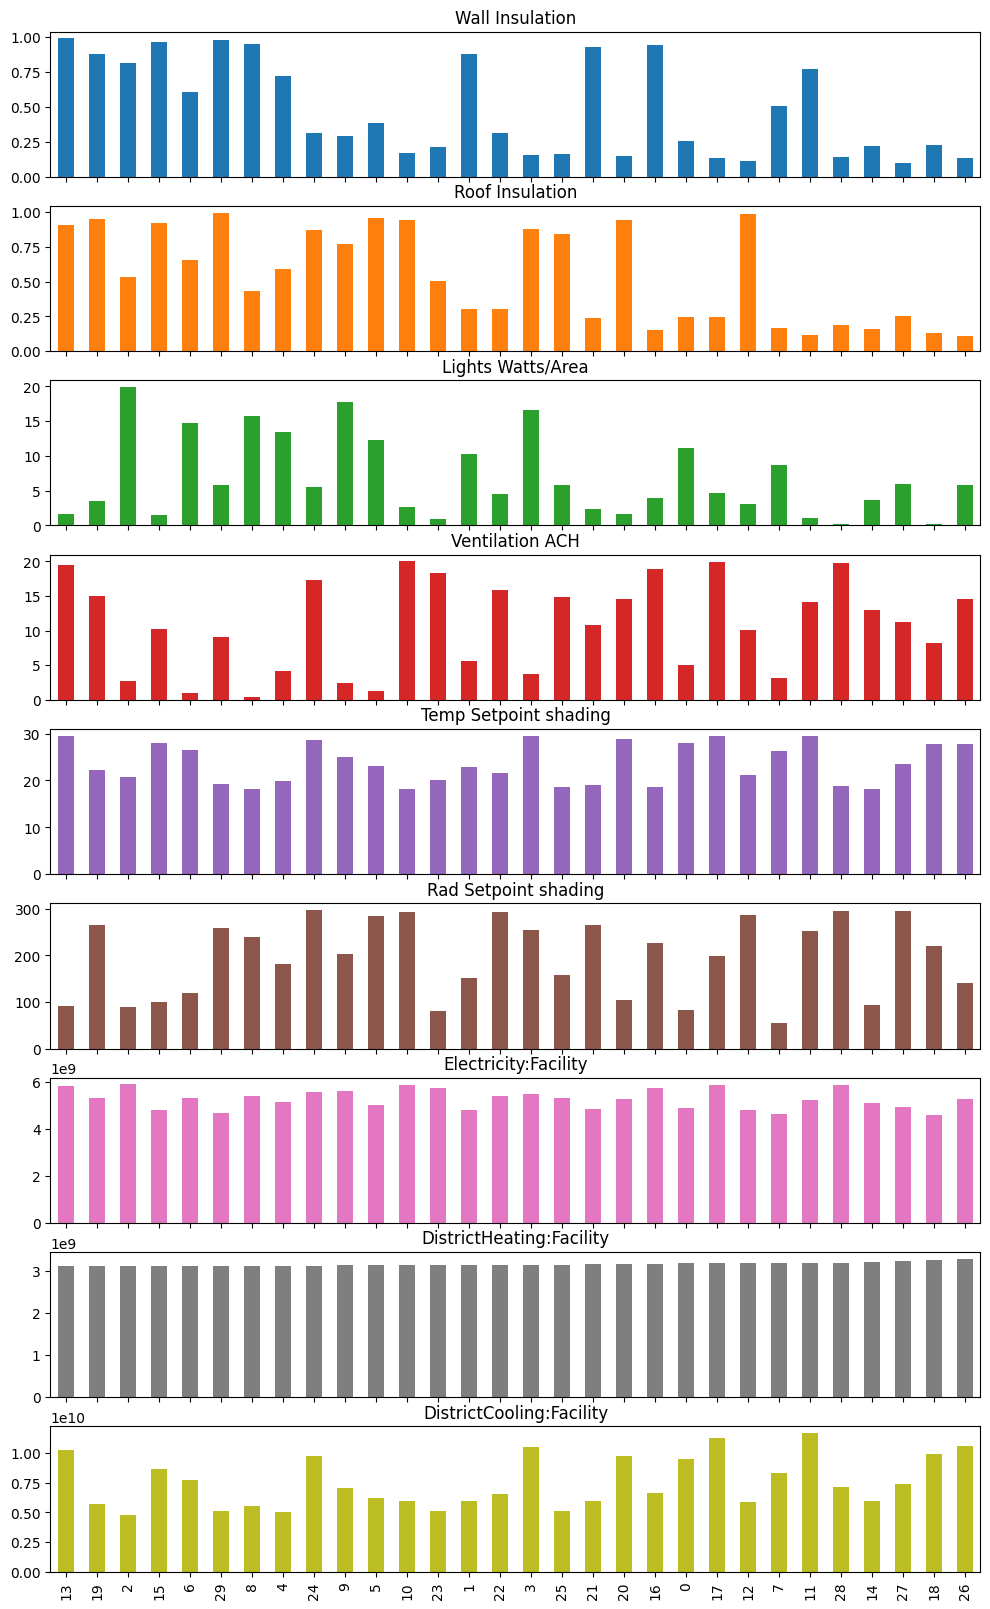

In [35]:
samples_original_df = samples_original_df.sort_values(by=output_cols[1])
ax=samples_original_df.plot.bar(subplots=True,legend=None, figsize=(12,20))

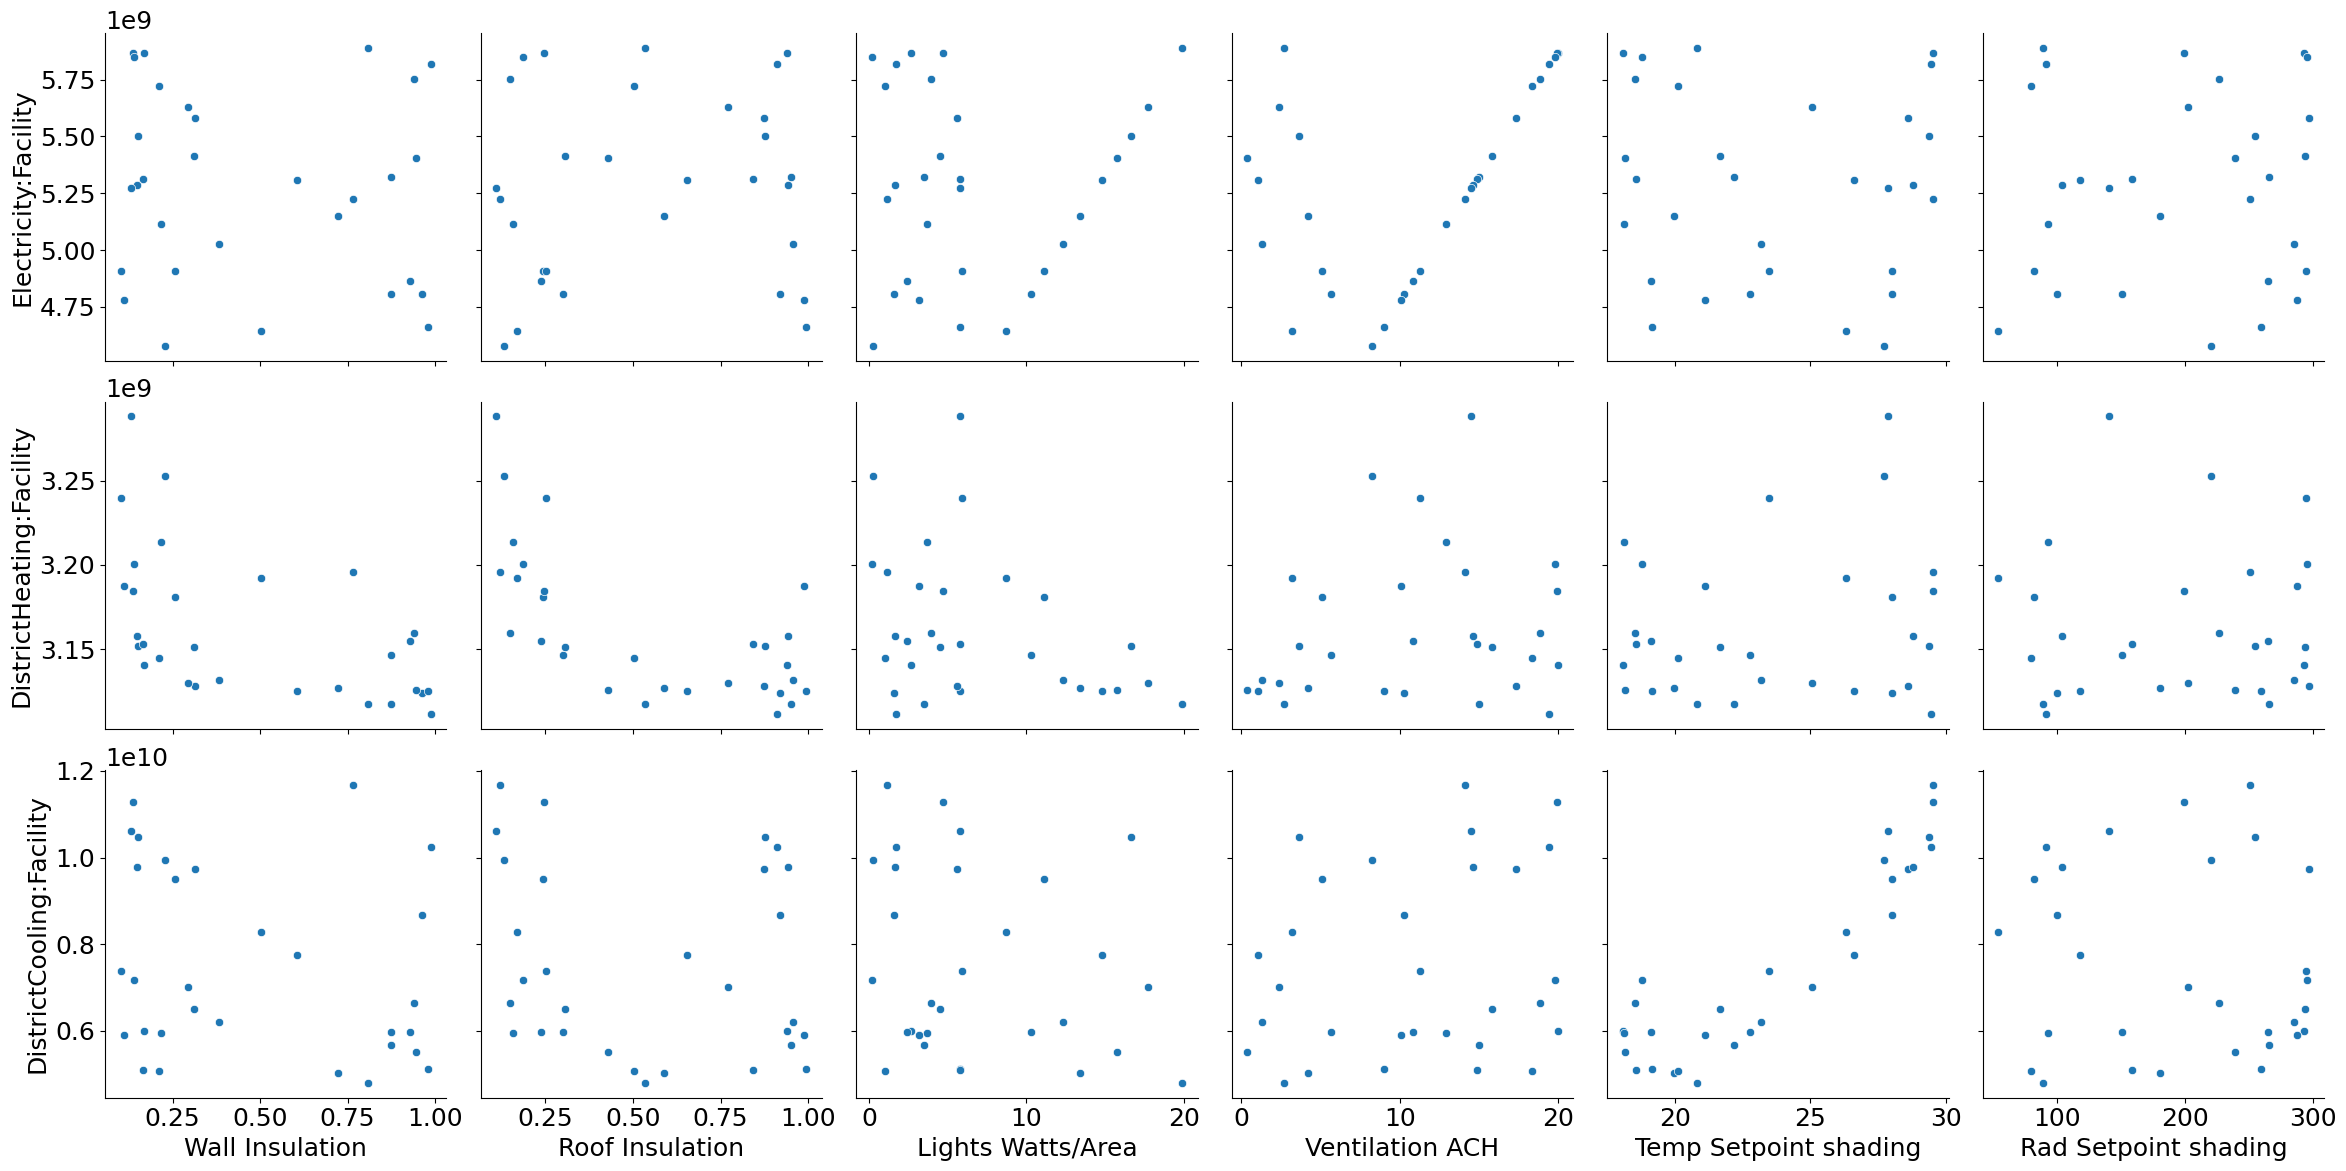

In [36]:
plt.rcParams.update({'font.size': 18})
_=pairplot(samples_original_df,x_vars=input_cols, y_vars=objectives, kind="scatter",height=4)

In [37]:
corr=samples_original_df.corr()
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
Wall Insulation,1.000000,0.067710,0.121431,-0.210556,-0.145405,-0.108980,-0.115249,-0.542379,-0.232215
Roof Insulation,0.067710,1.000000,0.120787,-0.062294,0.022077,0.126203,0.093263,-0.656212,-0.195906
Lights Watts/Area,0.121431,0.120787,1.000000,-0.806048,-0.002815,-0.138389,0.087756,-0.346429,-0.210525
Ventilation ACH,-0.210556,-0.062294,-0.806048,1.000000,-0.045630,0.175761,0.447787,0.182837,0.195115
Temp Setpoint shading,-0.145405,0.022077,-0.002815,-0.045630,1.000000,-0.252216,-0.070631,0.180792,0.904535
Rad Setpoint shading,-0.108980,0.126203,-0.138389,0.175761,-0.252216,1.000000,0.046731,0.022236,-0.108336
Electricity:Facility,-0.115249,0.093263,0.087756,0.447787,-0.070631,0.046731,1.000000,-0.291149,0.038053
DistrictHeating:Facility,-0.542379,-0.656212,-0.346429,0.182837,0.180792,0.022236,-0.291149,1.000000,0.401438
DistrictCooling:Facility,-0.232215,-0.195906,-0.210525,0.195115,0.904535,-0.108336,0.038053,0.401438,1.000000


In [38]:
corr.drop(objectives, axis = 1, inplace = True)
corr.drop(['Roof Insulation','Wall Insulation', 'Lights Watts/Area','Ventilation ACH','Temp Setpoint shading', 'Rad Setpoint shading'], axis = 0 ,inplace = True)
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
Electricity:Facility,-0.115249,0.093263,0.087756,0.447787,-0.070631,0.046731
DistrictHeating:Facility,-0.542379,-0.656212,-0.346429,0.182837,0.180792,0.022236
DistrictCooling:Facility,-0.232215,-0.195906,-0.210525,0.195115,0.904535,-0.108336


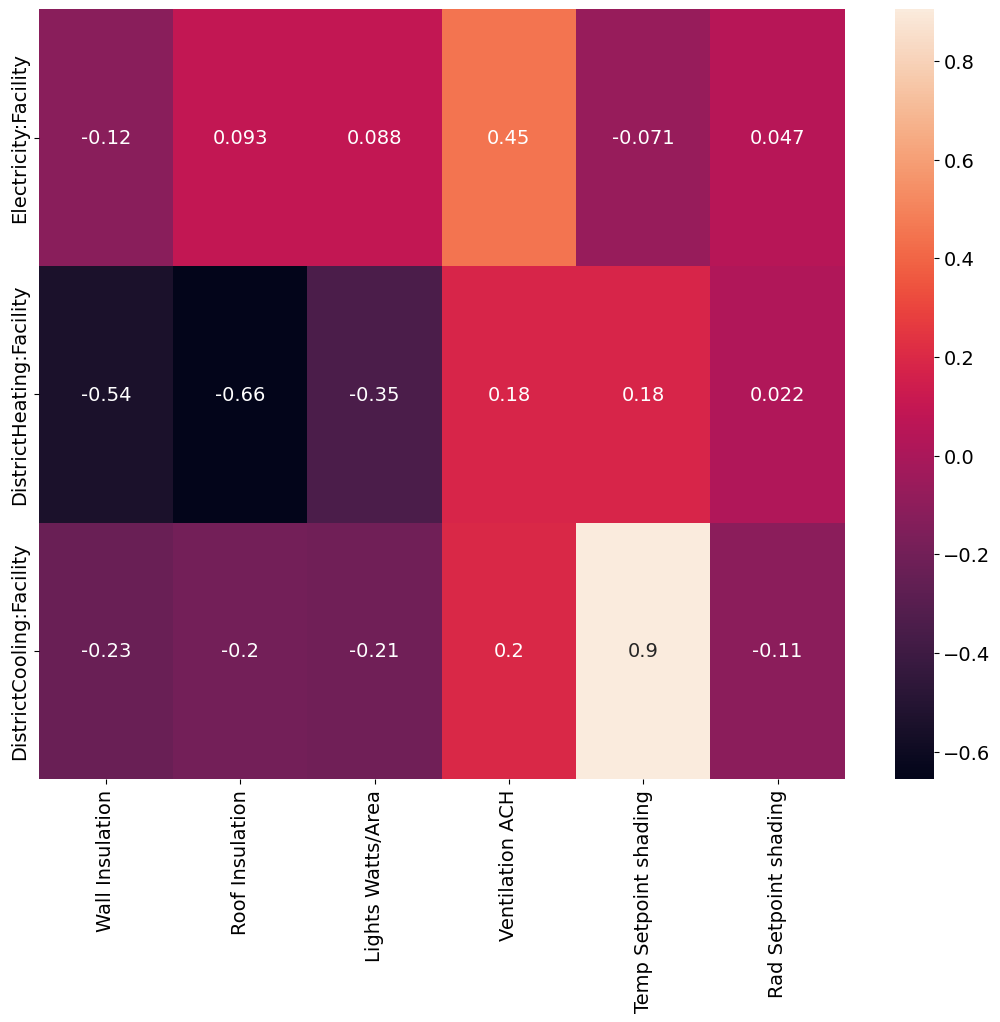

In [39]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)

In [40]:
train_in, test_in, train_out, test_out = train_test_split(
    inputs_original_df, outputs_original_df, test_size=0.2
)

In [41]:
#second scaling we turn again the original samples in to scaled dataset to train and test surrogate models

scaler = StandardScaler()
train_in_scale = scaler.fit_transform(X=train_in)
test_in_scale = scaler.fit_transform(X=test_in)

scaler_out = StandardScaler()
train_out_scale = scaler_out.fit_transform(X=train_out)
test_out_scale = scaler_out.fit_transform(X=test_out)

In [42]:
hyperparameters = {
    "kernel": [
        None,
        1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
        1.0 * RationalQuadratic(length_scale=1.0, alpha=0.5),
        # ConstantKernel(0.1, (0.01, 10.0))*(DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0))**2),
        1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
    ]
}

folds = 3

gp = GaussianProcessRegressor(normalize_y=True)

clf = GridSearchCV(gp, hyperparameters, cv=folds)

clf.fit(train_in_scale, train_out_scale)

best_gp = clf.best_estimator_ 

prediction_gp = scaler_out.inverse_transform(best_gp.predict(test_in_scale))

In [43]:
hyperparameters = {
    "hidden_layer_sizes": (
        (len(parameters) * 16,),
        (len(parameters) * 16, len(parameters) * 16),
    ),
    "alpha": [1, 10, 10 ** 3],
}

neural_net = MLPRegressor(max_iter=1000, early_stopping=False)
folds = 3

clf = GridSearchCV(neural_net, hyperparameters, cv=folds)
clf.fit(train_in_scale, train_out_scale)

nn_model = clf.best_estimator_

prediction_nn = scaler_out.inverse_transform(nn_model.predict(test_in_scale))

In [44]:
def build_model():
    model = keras.Sequential(
        [
            layers.Input(shape=(train_in_scale.shape[1], )),
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(3),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])
    return model

tf_model = build_model()

tf_model.summary()

EPOCHS = 1000

history = tf_model.fit(
    train_in_scale,
    train_out_scale,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
)

prediction_tf = scaler_out.inverse_transform(tf_model.predict(test_in_scale))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,515 (17.64 KB)

 Trainable params: 4,515 (17.64 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [45]:
mse = mean_squared_error(prediction_gp,
                         test_out.values,
                         multioutput='raw_values')

# 2) RMSE
rmse = np.sqrt(mse)

mean_vals = test_out.mean().values
rmse_pct = rmse / mean_vals * 100


print("GP:")
print("RMSE:", rmse)
print("RMSE %:", rmse_pct)

GP:
RMSE: [1.60279963e+08 3.51899054e+07 6.24990211e+08]
RMSE %: [2.97417099 1.1064885  8.42878809]


In [46]:
mse_nn = mean_squared_error(
    prediction_nn,
    test_out.values,
    multioutput='raw_values'
)

# 2) RMSE
rmse_nn = np.sqrt(mse_nn)

mean_vals = test_out.mean().values
rmse_pct_nn = rmse_nn / mean_vals * 100

print("NN:")
print("RMSE NN:", rmse_nn)
print("RMSE % NN:", rmse_pct_nn)

NN:
RMSE NN: [1.94660682e+08 2.26277423e+07 4.45282664e+08]
RMSE % NN: [3.61214303 0.71149201 6.0052032 ]


In [47]:
mse_tf = mean_squared_error(
    prediction_tf,
    test_out.values,
    multioutput='raw_values'
)

# 2) RMSE
rmse_tf = np.sqrt(mse_tf)

mean_vals = test_out.mean().values
rmse_pct_tf = rmse_tf / mean_vals * 100


print("TF:")
print("RMSE TensorFlow:", rmse_tf)
print("RMSE % TensorFlow:", rmse_pct_tf)

TF:
RMSE TensorFlow: [3.34825982e+08 2.51625575e+07 6.05827331e+08]
RMSE % TensorFlow: [6.21306433 0.7911951  8.17035227]


In [48]:
parameters = insulation_param + [lights_param]  + ventilationAchParam + setpointParams

objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility']

In [49]:
def evaluation_func(ind, scaler=scaler):
    ind = scaler.transform(X=[ind])
    return (scaler_out.inverse_transform(best_gp.predict(ind))[0]).tolist()

evaluator = EvaluatorGeneric(evaluation_func, problem)

srinputs = sampling.dist_sampler(sampling.lhs, problem, 500)
sroutputs = evaluator.df_apply(srinputs)
srresults = srinputs.join(sroutputs)
srresults.head()

Executing:   0%|          | 0/500 [00:00<?, ?row/s]

,Wall Insulation,Roof Insulation,Ventilation ACH,Lights Watts/Area,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.470097,0.189863,1.128104,13.668217,22.907514,141.932282,5.285043e+09,3.189697e+09,7.470043e+09
1,0.417326,0.987226,4.678349,10.970647,20.990565,121.571404,5.216388e+09,3.167285e+09,7.598141e+09
2,0.635389,0.867148,1.196594,13.309787,22.742198,171.381072,5.235848e+09,3.166473e+09,7.403834e+09
3,0.346583,0.226735,5.373779,19.847723,29.719675,67.559525,5.801736e+09,3.182775e+09,1.111342e+10
4,0.396113,0.110481,3.699047,11.580668,26.395210,264.140873,5.152667e+09,3.264500e+09,1.002106e+10


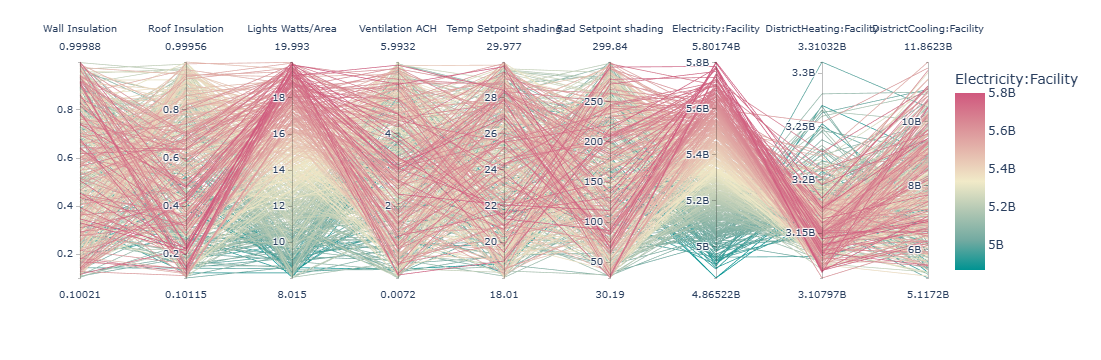

In [50]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

features = input_cols
import plotly.express as px
fig = px.parallel_coordinates(srresults,color="Electricity:Facility", dimensions=features+objectives,
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

In [51]:
from platypus import Problem, Real, NSGAII
import numpy as np

# 1) Número de variables y de objetivos
d = len(features)
m = len(objectives)

# 2) Monta el problema Platypus “a mano”
plat_prob = Problem(d, m)
plat_prob.types[:] = [
    Real(param.value_descriptor.min, param.value_descriptor.max)
    for param in parameters
]
plat_prob.function = lambda xs: tuple(evaluation_func(xs))

# 3) Corre NSGA-II
algo = NSGAII(plat_prob, population_size=10000)
algo.run(5000)

# 4) Saca tu frente Pareto
pareto = algo.result
objectives_array = np.array([sol.objectives for sol in pareto])

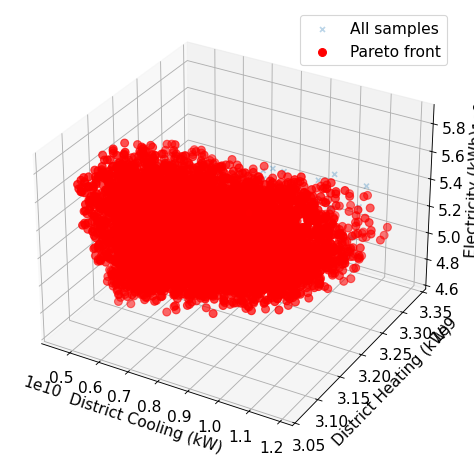

In [52]:
pareto_sols = algo.result
X_pareto = np.array([sol.variables  for sol in pareto_sols])
Y_pareto = np.array([sol.objectives for sol in pareto_sols])

# 2) Montar DataFrame de Pareto con las mismas columnas que srresults
opt_df = pd.DataFrame(
    np.hstack([X_pareto, Y_pareto]),
    columns=features + objectives
)

# 3) Graficar todo el muestreo inicial y el frente Pareto en 3D
fig = plt.figure(figsize=(8, 6), dpi=80)
ax  = fig.add_subplot(111, projection='3d')

# Muestreo inicial en azul con cruces
ax.scatter(
    srresults["DistrictCooling:Facility"],
    srresults["DistrictHeating:Facility"],
    srresults["Electricity:Facility"],
    marker='x', alpha=0.3, label='All samples'
)

# Frontera de Pareto en rojo con círculos
ax.scatter(
    opt_df["DistrictCooling:Facility"],
    opt_df["DistrictHeating:Facility"],
    opt_df["Electricity:Facility"],
    c='r', marker='o', s=50, label='Pareto front'
)

ax.set_xlabel("District Cooling (kW)")
ax.set_ylabel("District Heating (kW)")
ax.set_zlabel("Electricity (kWh)")
ax.legend()
plt.tight_layout()
plt.show()

In [53]:
opt_df

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.688427,0.323097,12.959495,3.321459,24.078055,78.489437,5.235757e+09,3.138602e+09,7.638611e+09
1,0.472638,0.604971,13.605333,0.047002,28.591628,127.581337,5.327504e+09,3.127676e+09,1.030243e+10
2,0.369939,0.173337,13.200116,0.546271,21.972406,139.182590,5.082361e+09,3.230319e+09,6.776097e+09
3,0.120043,0.172598,15.687891,2.139305,25.175096,60.679626,5.365804e+09,3.236240e+09,8.604616e+09
4,0.929643,0.478713,14.947478,2.669957,27.743531,233.411346,5.379799e+09,3.104849e+09,9.329345e+09
...,...,...,...,...,...,...,...,...,...
9995,0.499242,0.215576,11.643242,0.245271,24.836523,242.669866,4.974684e+09,3.228743e+09,8.166052e+09
9996,0.923588,0.401879,17.477661,0.640878,22.945692,110.665716,5.575717e+09,3.094360e+09,6.753571e+09
9997,0.500250,0.156744,14.288902,1.174311,25.540071,145.620799,5.190119e+09,3.210809e+09,8.564492e+09
9998,0.790313,0.553250,19.660199,0.738029,22.587121,246.797543,5.672865e+09,3.068430e+09,6.814896e+09


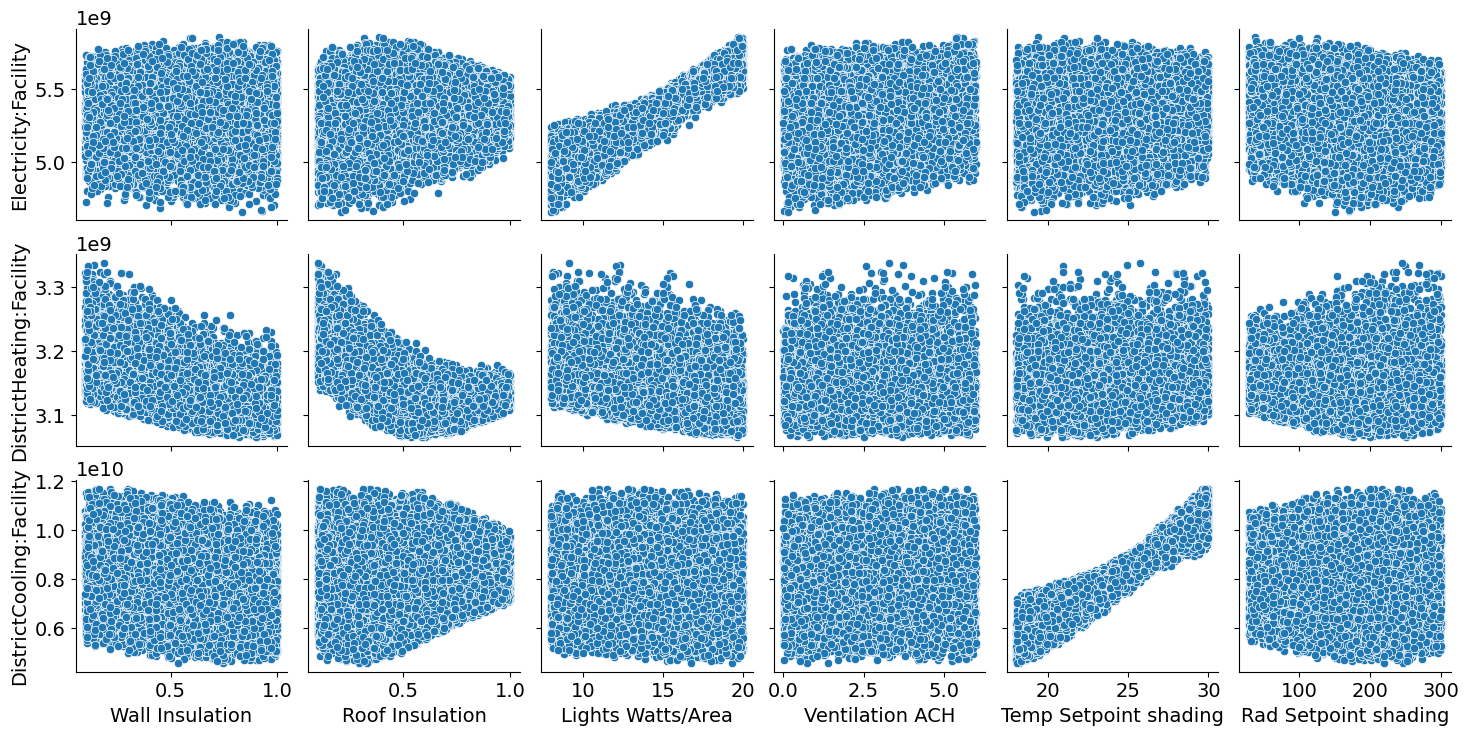

In [54]:
_=pairplot(opt_df,x_vars=input_cols, y_vars=objectives, kind="scatter")

In [55]:
pareto_sols = algo.result  # o NSGAII(...) según tu opción B
X_pareto = np.array([sol.variables  for sol in pareto_sols])
Y_pareto = np.array([sol.objectives for sol in pareto_sols])
opt_df = pd.DataFrame(np.hstack([X_pareto, Y_pareto]), columns=features + objectives)

In [56]:
corr=opt_df.corr()

corr.drop(objectives, axis = 1, inplace = True)
corr.drop(features, axis = 0 ,inplace = True)
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
Electricity:Facility,-0.045078,0.170866,0.929008,0.106140,0.141201,-0.099098
DistrictHeating:Facility,-0.485504,-0.617604,-0.322993,-0.021544,0.075616,0.031201
DistrictCooling:Facility,-0.155030,0.121021,-0.001640,0.007003,0.945263,-0.018080


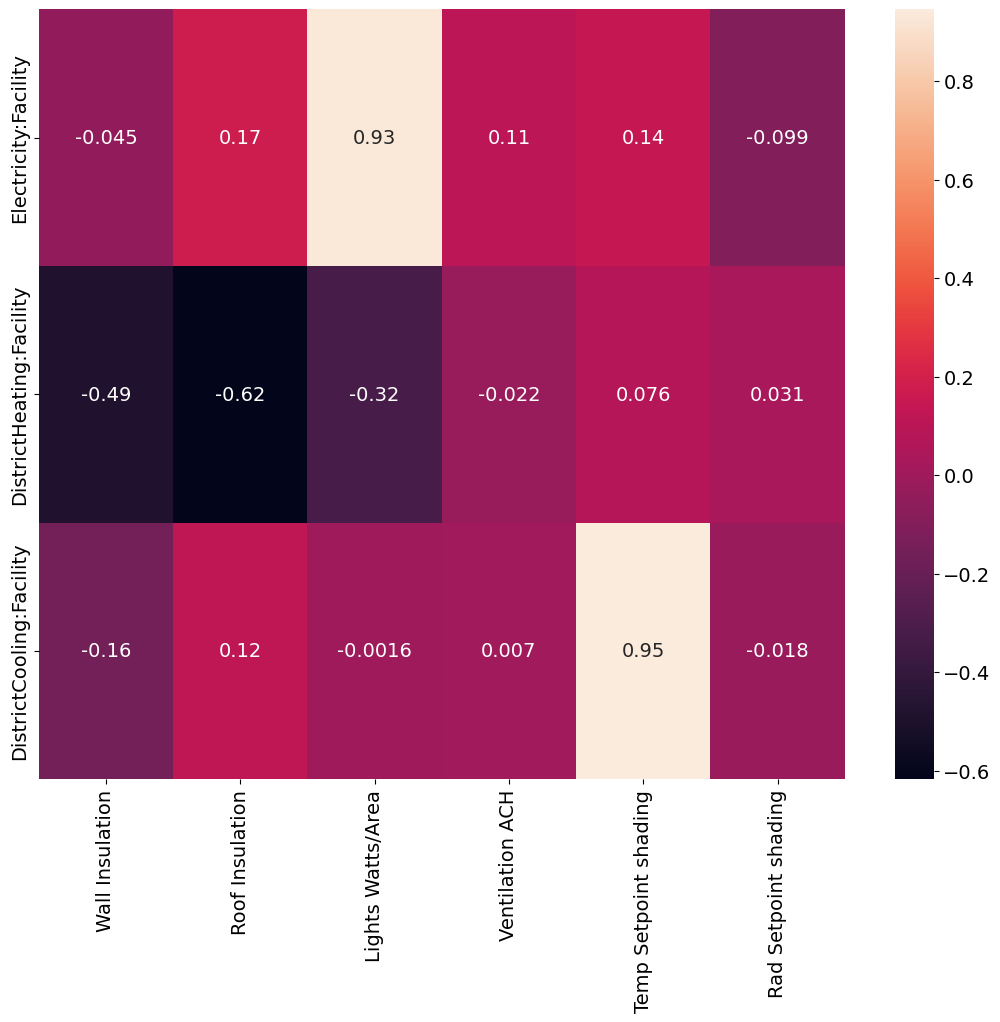

In [57]:
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)

In [58]:
opt_df['Total'] = opt_df['Electricity:Facility'] + opt_df['DistrictHeating:Facility'] + opt_df['DistrictCooling:Facility']
opt_df['Dist'] = opt_df.apply(lambda row : np.sqrt(pow(row["DistrictCooling:Facility"],2) + pow(row["DistrictHeating:Facility"],2) + pow(row["Electricity:Facility"],2)),axis=1)

opt_df[opt_df.Dist == opt_df.Dist.min()]

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Total,Dist
7055,0.802309,0.292588,8.856775,3.23365,18.075745,199.314868,4.776334e+09,3.158159e+09,4.911357e+09,1.284585e+10,7.543790e+09


In [59]:
optimal_params=opt_df.loc[opt_df.Dist == opt_df.Dist.min(),features].to_dict('records')[0]
optimal_params

{'Wall Insulation': 0.8023092823991361,
 'Roof Insulation': 0.29258758050548367,
 'Lights Watts/Area': 8.856775393073253,
 'Ventilation ACH': 3.233650111429808,
 'Temp Setpoint shading': 18.07574486109744,
 'Rad Setpoint shading': 199.31486762464027}